In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects
import seaborn as sns
import os
import random
import colorsys
import json
from matplotlib.patches import Rectangle
import chardet

def read_csv_with_encoding(file_path, header=None):
    """
    Membaca file CSV dengan deteksi encoding otomatis.
    """
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    encoding = result['encoding']
    try:
        return pd.read_csv(file_path, encoding=encoding, header=header)
    except Exception as e:
        raise ValueError(f"Gagal membaca file {file_path} dengan encoding {encoding}: {e}")

def convert_to_number(x):
    """Convert string ke number (int atau float) jika memungkinkan."""
    if x == '-' or x == '' or x.isspace():
        return None
    try:
        num = float(x)
        return int(num) if num.is_integer() else num
    except (ValueError, TypeError):
        return None

def format_value(value):
    if value is None:
        return ""
    if np.issubdtype(type(value), np.integer):
        return f"{value:,}"
    elif np.issubdtype(type(value), np.floating):
        return f"{value:,.2f}"
    return str(value)

def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    return obj

def extract_barchart_annotations(fig, ax, bars, categories, values, orientation='vertical'):
    """
    Mengekstrak anotasi dari barchart.
    
    Menghasilkan dictionary dengan format:
      {
         "models": [
              {
                 "name": <label>,
                 "color": <warna bar>,
                 "bboxes": <bounding box dari bar (display coordinates)>,
                 "x": <x-value datapoint>,
                 "y": <y-value datapoint>
              },
              ...
         ],
         "type": "v_bar" atau "h_bar",
         "general_figure_info": {
              "title": {"text": <judul>, "bbox": <bounding box>},
              "x_axis": [ { "text": <label>, "bbox": <bounding box> }, ... ],
              "y_axis": [ { "text": <label>, "bbox": <bounding box> }, ... ],
              "legend": { "texts": [..], "bbox": <bounding box> },
              "figure_info": <bounding box plot>
         }
      }
    """
    renderer = fig.canvas.get_renderer()

    # Ekstrak judul chart
    title_text = ax.get_title()
    title_obj = ax.title
    title_bbox = title_obj.get_window_extent(renderer=renderer).bounds if title_obj is not None else None

    # Ekstrak label sumbu X
    xtick_objs = ax.get_xticklabels()
    x_axis = []
    for tick in xtick_objs:
        text = tick.get_text()
        if text:
            bbox = tick.get_window_extent(renderer=renderer).bounds
            x_axis.append({'text': text, 'bbox': bbox})

    # Ekstrak label sumbu Y
    ytick_objs = ax.get_yticklabels()
    y_axis = []
    for tick in ytick_objs:
        text = tick.get_text()
        if text:
            bbox = tick.get_window_extent(renderer=renderer).bounds
            y_axis.append({'text': text, 'bbox': bbox})

    # Ekstrak informasi legend, jika ada
    leg = ax.get_legend()
    legend = {}
    if leg is not None:
        legend_bbox = leg.get_window_extent(renderer=renderer).bounds
        legend_texts = [t.get_text() for t in leg.get_texts()]
        legend = {'texts': legend_texts, 'bbox': legend_bbox}

    # Bounding box area plot (axes)
    figure_bbox = ax.get_window_extent(renderer=renderer).bounds

    general_info = {
        "title": {"text": title_text, "bbox": title_bbox},
        "x_axis": x_axis,
        "y_axis": y_axis,
        "legend": legend,
        "figure_info": figure_bbox
    }

    models = []
    for bar, cat, val in zip(bars, categories, values):
        bbox = bar.get_window_extent(renderer=renderer).bounds
        color = bar.get_facecolor()
        if orientation == 'vertical':
            x_val = bar.get_x() + bar.get_width()/2.
            y_val = bar.get_height()
        else:  # horizontal
            x_val = bar.get_width()
            y_val = bar.get_y() + bar.get_height()/2.
        model = {
            "name": cat,
            "color": color,
            "bboxes": bbox,
            "x": x_val,
            "y": y_val
        }
        models.append(model)

    chart_type = "v_bar" if orientation == 'vertical' else "h_bar"
    return {"models": models, "type": chart_type, "general_figure_info": general_info}

def generate_multi_style_barcharts(csv_path, metadata_path, output_image_dir=None, output_info_dir=None):
    """
    Membuat berbagai style barchart dari data tabel dan menyimpan informasi anotasinya.
    
    Selain menyimpan gambar, fungsi ini juga membuat file JSON yang menyimpan:
      - models: list anotasi untuk tiap bar.
      - type: jenis chart (v_bar/h_bar).
      - general_figure_info: informasi umum seperti judul, sumbu, legenda, dan bounding box plot.
    """
    if output_image_dir is None:
        output_image_dir = os.path.dirname(csv_path)
    if output_info_dir is None:
        output_info_dir = os.path.dirname(csv_path)

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_info_dir, exist_ok=True)

    # Baca metadata
    metadata_df = read_csv_with_encoding(metadata_path, header=0)
    table_id = os.path.splitext(os.path.basename(csv_path))[0]
    metadata_row = metadata_df[metadata_df['Table ID'] == table_id]
    if metadata_row.empty:
        print(f"Metadata untuk Table ID {table_id} tidak ditemukan. Melewati file ini.")
        return None

    judul = metadata_row['Judul Tabel'].values[0]
    tahun = metadata_row['Tahun'].values[0]
    title = f"{judul} Tahun {tahun}"

    df = read_csv_with_encoding(csv_path, header=None)
    data = df.iloc[1:-1]
    data_dict = {}
    no_data_categories = []
    for idx, row in data.iterrows():
        category = row[0]
        value = convert_to_number(row[1])
        if value is None:
            no_data_categories.append(category)
        else:
            data_dict[category] = value

    categories = list(data_dict.keys())
    values = list(data_dict.values())

    highest_value = max(values)
    lowest_value = min(values)
    highest_category = categories[values.index(highest_value)]
    lowest_category = categories[values.index(lowest_value)]
    
    base_filename = os.path.splitext(os.path.basename(csv_path))[0]
    image_paths = {
        'column_a': os.path.join(output_image_dir, f"{base_filename}_column_a.png"),
        'column_b': os.path.join(output_image_dir, f"{base_filename}_column_b.png"),
        'column_c': os.path.join(output_image_dir, f"{base_filename}_column_c.png"),
        'bar_a': os.path.join(output_image_dir, f"{base_filename}_bar_a.png"),
        'bar_b': os.path.join(output_image_dir, f"{base_filename}_bar_b.png")
    }
    info_path = os.path.join(output_info_dir, f"{base_filename}_barchart_info.json")

    chart_info = {
        'title': title,
        'data': data_dict,
        'no_data_categories': no_data_categories,
        'total': sum(values),
        'num_categories': len(categories),
        'highest': {'category': highest_category, 'value': highest_value},
        'lowest': {'category': lowest_category, 'value': lowest_value}
    }

    def add_no_data_note(fig, ax, no_data_categories):
        if no_data_categories:
            note_text = "No data available for: " + ", ".join(no_data_categories)
            fig.text(0.5, 0.02, note_text, ha='center', va='center', 
                     fontsize=10, style='italic', color='gray', wrap=True)
            plt.subplots_adjust(bottom=0.2)

    styles_info = {}

    # =================================== COLUMN CHART ==================================

    # Style A: Viridis-themed column chart with moderate contrast and numeric annotations
    style_a = chart_info.copy()
    fig, ax = plt.subplots(figsize=(12, 8))
    gradient_colors = plt.cm.viridis(np.linspace(0, 0.8, len(categories)))
    bars = ax.bar(categories, values, color=gradient_colors)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                format_value(height),
                ha='center', va='bottom')
    
    ax.set_title(title, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
    add_no_data_note(fig, ax, no_data_categories)
    plt.tight_layout()
    # Pastikan renderer telah diupdate
    fig.canvas.draw()
    annotations = extract_barchart_annotations(fig, ax, bars, categories, values, orientation='vertical')
    style_a["annotations"] = annotations
    plt.savefig(image_paths['column_a'], dpi=300, bbox_inches='tight')
    plt.close()
    styles_info['column_a'] = style_a

    # Style B: Neon-themed column chart on dark background with custom legend
    style_b = chart_info.copy()
    plt.style.use('dark_background')
    # fig, ax = plt.subplots(figsize=(14, 7))
    fig, ax = plt.subplots(figsize=(12, 8))
    neon_colors = ['#FF1E1E', '#FF901E', '#3FFF1E', '#1EFFF4', '#1E45FF']
    bars = ax.bar(categories, values, color=neon_colors[:len(categories)])
    
    # Buat legend dengan label kategori dan nilai
    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color) 
                      for color in neon_colors[:len(categories)]]
    legend_labels = [f"{cat}\n{format_value(val)}" for cat, val in zip(categories, values)]
    ax.legend(legend_elements, legend_labels, title="Details",
              bbox_to_anchor=(1.05, 1), loc='upper left', labelspacing=1)
    
    ax.set_title(title, color='white')
    plt.xticks(rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.2)
    add_no_data_note(fig, ax, no_data_categories)
    plt.tight_layout()
    fig.canvas.draw()
    annotations = extract_barchart_annotations(fig, ax, bars, categories, values, orientation='vertical')
    style_b["annotations"] = annotations
    plt.savefig(image_paths['column_b'], dpi=300, bbox_inches='tight',
                facecolor='black', edgecolor='none')
    plt.style.use('default')
    plt.close()
    styles_info['column_b'] = style_b

    # Style C: Sorted column chart with coolwarm palette and subtle label shadows
    style_c = chart_info.copy()

    sorted_pairs = sorted(zip(values, categories), reverse=True)
    values_sorted, categories_sorted = zip(*sorted_pairs)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    gradient_colors = [plt.cm.coolwarm(i/len(categories_sorted)) for i in range(len(categories_sorted))]
    bars = ax.bar(categories_sorted, values_sorted, color=gradient_colors,
                  edgecolor='white', linewidth=1.5, zorder=3)
    
    for bar in bars:
        height = bar.get_height()
        txt = ax.text(bar.get_x() + bar.get_width()/2., height,
                      format_value(height),
                      ha='center', va='bottom', fontweight='bold')
        txt.set_path_effects([
            patheffects.withSimplePatchShadow(offset=(1, -1),
                                              shadow_rgbFace='gray',
                                              alpha=0.3)
        ])
    
    ax.set_title(title, pad=20, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_edgecolor('#CCCCCC')
    
    add_no_data_note(fig, ax, no_data_categories)
    plt.tight_layout()
    fig.canvas.draw()
    
    # Gunakan data yang sudah diurutkan untuk anotasi style_c
    annotations = extract_barchart_annotations(fig, ax, bars, categories_sorted, values_sorted, orientation='vertical')
    style_c["annotations"] = annotations
    
    plt.savefig(image_paths['column_c'], dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    
    styles_info['column_c'] = style_c

    # ==================================== BAR CHART ====================================

    # Style D: Basic bar chart with centered labels and pastel Set3 color palette
    style_d = chart_info.copy()
    # fig, ax = plt.subplots(figsize=(12, max(6, len(categories) * 0.5)))
    fig, ax = plt.subplots(figsize=(12, 8))
    colors_b = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    bars = ax.barh(categories, values, color=colors_b)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width/2, bar.get_y() + bar.get_height()/2,
                format_value(width),
                ha='center', va='center')
    
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    add_no_data_note(fig, ax, no_data_categories)
    plt.tight_layout()
    fig.canvas.draw()
    annotations = extract_barchart_annotations(fig, ax, bars, categories, values, orientation='horizontal')
    style_d["annotations"] = annotations
    plt.savefig(image_paths['bar_a'], dpi=300, bbox_inches='tight')
    plt.close()
    styles_info['bar_a'] = style_d

    # Style E: Sorted bar chart with Tab20 colormap and right-aligned external value labels
    style_e = chart_info.copy()
    
    sorted_pairs = sorted(zip(values, categories), reverse=False)
    values, categories = zip(*sorted_pairs)
    
    # fig, ax = plt.subplots(figsize=(12, max(6, len(categories) * 0.5)))
    fig, ax = plt.subplots(figsize=(12, 8))
    colors_d = plt.cm.tab20(np.linspace(0, 1, len(categories)))
    bars = ax.barh(categories, values, color=colors_d)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width + (max(values) * 0.02), bar.get_y() + bar.get_height()/2,
                format_value(width),
                va='center')
    
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    add_no_data_note(fig, ax, no_data_categories)
    plt.tight_layout()
    fig.canvas.draw()
    annotations = extract_barchart_annotations(fig, ax, bars, categories, values, orientation='horizontal')
    style_e["annotations"] = annotations
    plt.savefig(image_paths['bar_b'], dpi=300, bbox_inches='tight')
    plt.close()
    styles_info['bar_b'] = style_e

    with open(info_path, 'w', encoding='utf-8') as f:
        json.dump(convert_numpy_types(styles_info), f, indent=4, ensure_ascii=False)

    return {
        'image_paths': image_paths,
        'info_path': info_path,
        'styles_info': styles_info
    }


In [2]:
## SAMPLE USAGE
csv_file = '/kaggle/input/table-dataset/table-dataset-versi4/table-dataset-versi4/T1120.csv'
metadata_file = '/kaggle/input/table-dataset/metadata_tabel.csv'
output_image_dir = '/kaggle/working/sample'
output_info_dir = '/kaggle/working/sample-info'

result = generate_multi_style_barcharts(
    csv_path=csv_file,
    metadata_path=metadata_file,
    output_image_dir=output_image_dir,
    output_info_dir=output_info_dir
)

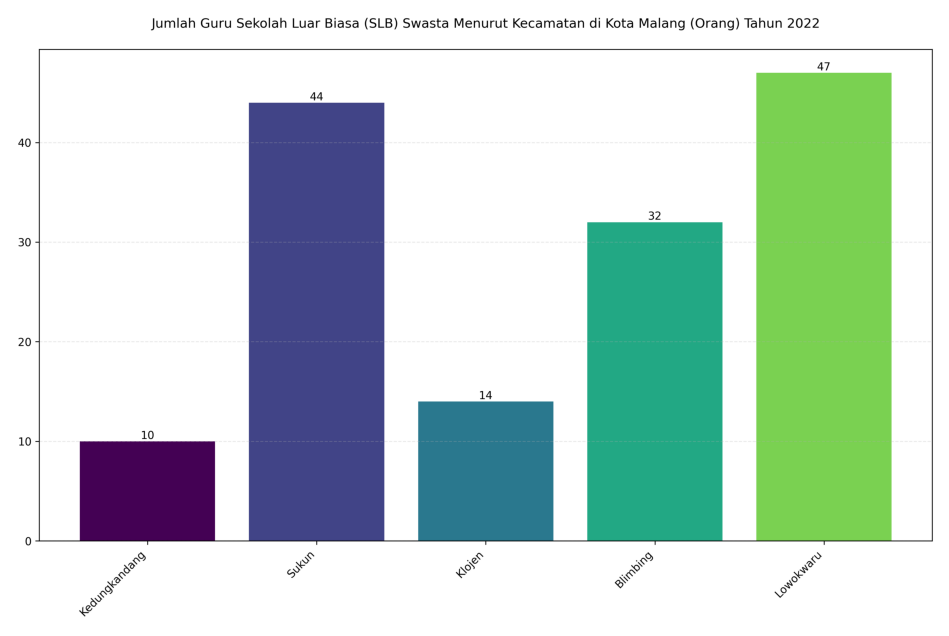

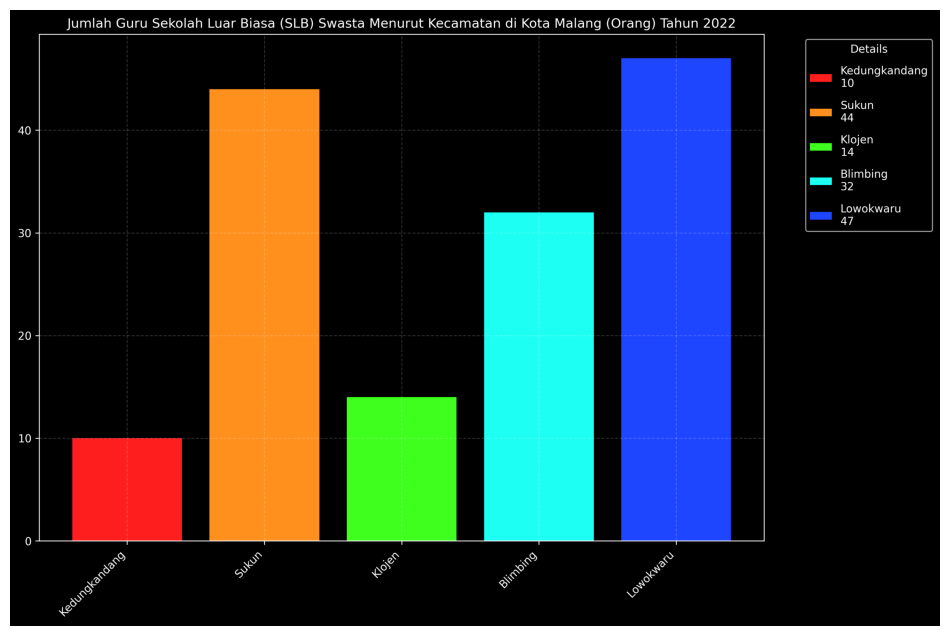

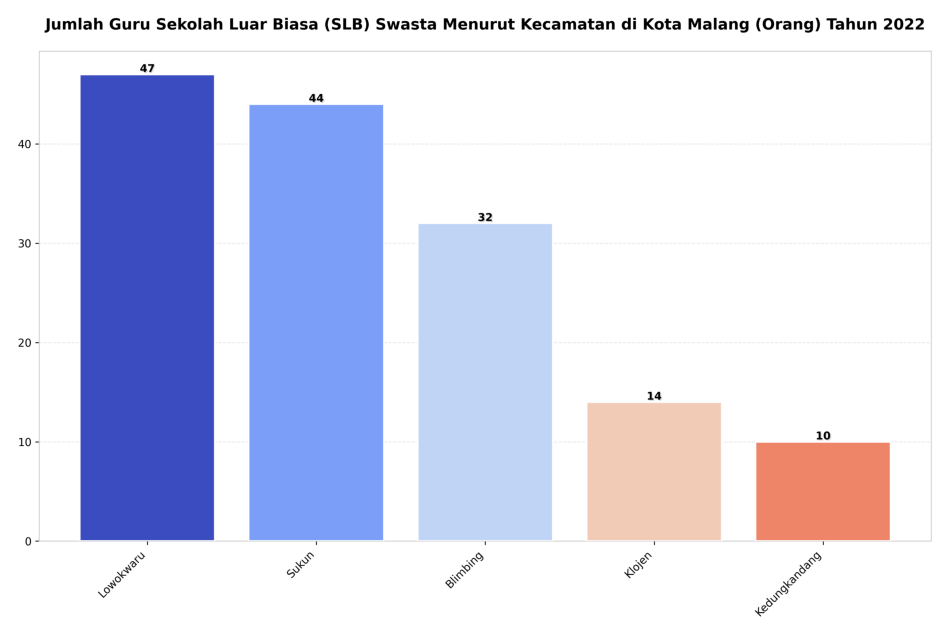

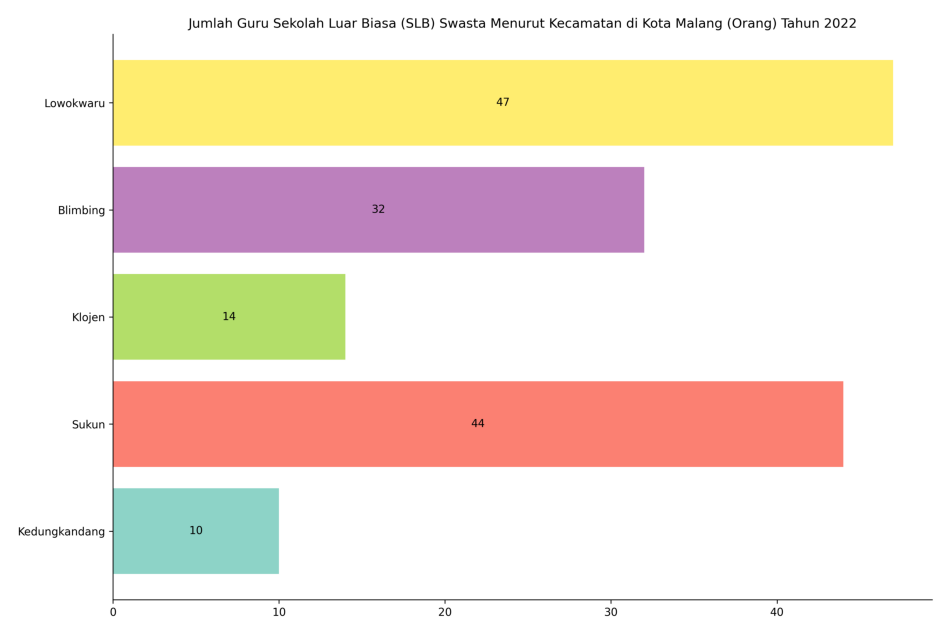

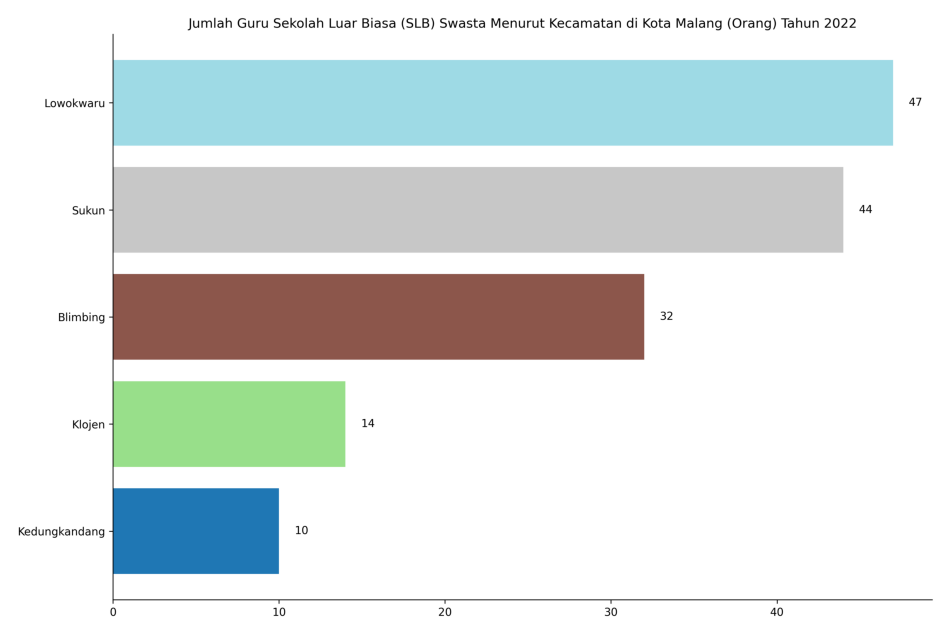

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for style, path in result['image_paths'].items():
    img = mpimg.imread(path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Batch function

In [4]:
def generate_batch_charts(input_dir, metadata_path, output_image_dir, output_info_dir):
    """
    Generate charts for multiple CSV files in a directory

    Parameters:
    input_dir (str): Directory containing CSV files
    output_image_dir (str): Directory to save chart images
    output_info_dir (str): Directory to save chart info files

    Returns:
    dict: Summary of processed files and any errors encountered
    """
    from tqdm.notebook import tqdm

    # Ensure output directories exist
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_info_dir, exist_ok=True)

    # Get all CSV files in input directory
    print(f"Checking files in directory: {input_dir}")
    csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.lower().endswith('.csv')]

    # Debug: Print found files
    # print(f"Debug: Found files: {csv_files}")

    # Initialize results tracking
    results = {
        'total_files': len(csv_files),
        'processed': 0,
        'errors': [],
        'successfully_processed': []
    }

    # Process each CSV file with progress bar
    print(f"Found {len(csv_files)} CSV files to process")

    for csv_file in tqdm(csv_files, desc="Generating charts"):
        try:
            # Generate charts for current file
            result = generate_multi_style_barcharts(
                csv_path=csv_file,
                metadata_path=metadata_file,
                output_image_dir=output_image_dir,
                output_info_dir=output_info_dir
            )

            # Track successful processing
            results['processed'] += 1
            results['successfully_processed'].append(os.path.basename(csv_file))

        except Exception as e:
            # Track any errors
            error_info = {
                'file': os.path.basename(csv_file),
                'error': str(e)
            }
            results['errors'].append(error_info)

    # Print summary
    print("\nProcessing Complete!")
    print(f"Successfully processed: {results['processed']} files")
    print(f"Errors encountered: {len(results['errors'])} files")

    # If there were any errors, print them
    if results['errors']:
        print("\nErrors:")
        for error in results['errors']:
            print(f"File: {error['file']}")
            print(f"Error: {error['error']}\n")

    return results

## Generate bar-charts with batch processing

In [5]:
input_dir = '/kaggle/input/table-dataset/table-dataset-versi4/table-dataset-versi4'
output_image_dir = '/kaggle/working/barchart-versi5'
output_info_dir = '/kaggle/working/barchart-info-versi5'
metadata_file = '/kaggle/input/table-dataset/metadata_tabel.csv'

# Run batch processing
batch_results = generate_batch_charts(
    input_dir=input_dir,
    metadata_path=metadata_file,
    output_image_dir=output_image_dir,
    output_info_dir=output_info_dir
)

# Optional: Save processing results to file
import json
results_file = os.path.join(output_info_dir, 'batch_processing_results.json')
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(batch_results, f, indent=4, ensure_ascii=False)

Checking files in directory: /kaggle/input/table-dataset/table-dataset-versi4/table-dataset-versi4
Found 1200 CSV files to process


Generating charts:   0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
import shutil
barchart_folder = "/kaggle/working/barchart-versi5"
output_barchart = "barchart-versi5.zip"

barchart_info_folder = "/kaggle/working/barchart-info-versi5"
output_info_barchart = "barchart-info-versi5.zip"

shutil.make_archive(output_barchart.replace('.zip', ''), 'zip', barchart_folder)
shutil.make_archive(output_info_barchart.replace('.zip', ''), 'zip', barchart_info_folder)

print(f"{output_barchart} berhasil dibuat.")
print(f"{output_info_barchart} berhasil dibuat.")